# Creating taxonomy databses

## Load crawled data

In [2]:
# read data

from datetime import datetime
from dateutil.parser import parse
import pandas as pd
import json

from nltk.sentiment.vader import SentimentIntensityAnalyzer

KEYWORDS = ['corn','oats','wheat','soybean','rice']
QUERIES = ['corn','oats','wheat','soybean','rice']
OUTPUT_PATH = './successful_farming/'


def load_data_sf():
    temp = []
    for query in QUERIES:
        with open(f'./successful_farming/{query}.json','r') as f:
            data = json.load(f)
            temp += data['data']
    df = pd.json_normalize(temp)
    return df
        

def load_data_fp():
    temp = []
    for query in QUERIES:
        with open(f'./financial_post/{query}.json','r') as f:
            data = json.load(f)
            temp += data['data']
    df = pd.json_normalize(temp)
    return df
        
    
    
def clean_sf(df):
    df = df.drop_duplicates()
    df['date'] = df['metadata'].apply(lambda x: datetime.strptime(x.split('|')[0].strip(),'%m.%d.%Y'))
    df['type'] = df['metadata'].apply(lambda x: x.split('|')[1].strip())
    del df['metadata']
    df = df[df['type']=='Article']
    
    # remove '3 big things today', 'Three commodities to watch'
    df = df[~df['headline'].str.contains('3 Big Things Today')]
    df = df[~df['headline'].str.contains('Three commodities to watch')]
    
    return df


def clean_fp(df):
    df = df.drop_duplicates()
    df = df[~df['metadata'].str.contains('ago')]
    df['date'] = df['metadata'].apply(parse)
    df = df[df['cat'].isin(['PMN Business','Agriculture','Business','PMN Agriculture'])]
    df['type'] = df['cat']
    del df['metadata']
    del df['cat']
    
    return df


- An example of the un-processed data frame

In [3]:
df_fp = load_data_fp()
df_fp = clean_fp(df_fp)

df_sf = load_data_sf()
df_sf = clean_sf(df_sf)

df = pd.concat([df_fp,df_sf])
df['hashtag'] = None
df['source'] = 'news'
df.head()

# concat with Twitter data after the colnames are uniformized

df_tweets = pd.read_csv('./tweets.csv',lineterminator='\n')
df = pd.concat([df, df_tweets])

<ipython-input-2-5993b734a9c0>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['metadata'].apply(lambda x: datetime.strptime(x.split('|')[0].strip(),'%m.%d.%Y'))
<ipython-input-2-5993b734a9c0>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'] = df['metadata'].apply(lambda x: x.split('|')[1].strip())


,headline,url,query,date,type,hashtag,source
27,"Wheat down 3%; soy, corn also sag on pre-holid...",/pmn/business-pmn/wheat-down-3-soy-corn-also-s...,corn,2020-11-25,PMN Business,None,news
28,Wheat pauses after three-week high in pre-holi...,/pmn/business-pmn/wheat-pauses-after-three-wee...,corn,2020-11-25,PMN Business,None,news
29,"Wheat gains for 4th session, at near 3-week to...",/pmn/business-pmn/wheat-gains-for-4th-session-...,corn,2020-11-25,PMN Business,None,news
30,Wheat hits near three-week high on USDA's crop...,/pmn/business-pmn/wheat-hits-near-three-week-h...,corn,2020-11-25,PMN Business,None,news
31,Wheat climbs to 2-week top on U.S. ratings; co...,/pmn/business-pmn/wheat-climbs-to-2-week-top-o...,corn,2020-11-24,PMN Business,None,news


## Assign scores using various analyzers and dictionaries

In [6]:
import pysentiment2 as ps
from textblob import TextBlob

# using textblob for polarity
# using LM dictionary
# using HIV4 dictionary
# using VADER

def generate_sentiment(df):
    lm = ps.LM()
    hiv4 = ps.HIV4()
    vader = SentimentIntensityAnalyzer()
    
    # VADER score
    df['VADER_compound'] = df['headline'].apply(lambda x: vader.polarity_scores(x)['compound'])

    # Harvard IV-4 dictionary - HIV4 score 
    df['HIV4_score'] = df['headline'].apply(lambda x: hiv4.get_score(hiv4.tokenize(x))['Polarity'])
    
    # Loughran and McDonald Financial Sentiment Dictionary - LM score
    df['LM_score'] = df['headline'].apply(lambda x: lm.get_score(lm.tokenize(x))['Polarity'])
    
    # TextBlob polarity - identifies negation
    df['TextBlob_polarity'] = df['headline'].apply(lambda x: TextBlob(x).sentiment[0])

    # TextBlob subjectivity
    df['TextBlob_subjectivity'] = df['headline'].apply(lambda x: TextBlob(x).sentiment[1])
    
    df = df.drop_duplicates(subset='headline')
    
    del df['url']
    del df['type']
    
    return df

df = generate_sentiment(df)

## Apply standard text pre-processing 

In [7]:
import spacy
import en_core_web_sm
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

nlp = en_core_web_sm.load()
stop_words = set(stopwords.words('english'))


def tokenize(h):
    tokens = word_tokenize(h)
    words = [word.lower() for word in tokens if word.isalpha()]
    words = [word for word in words if not word in stop_words]
    
    # stemming
    ps = PorterStemmer()
    words = [ps.stem(w) for w in words]

    # lemmatization
    Lemmatizer = WordNetLemmatizer()
    words = [Lemmatizer.lemmatize(w, pos='v') for w in words]
    
    return ' '.join(words)


def ner(h):
    h = re.sub(r'[^a-zA-Z ]*','',h).lower() # sub all except alphabets
    sen = nlp(h)
    return sen.ents
    
    
df['headline_tk'] = df['headline'].apply(tokenize)
df['ents'] = df['headline'].apply(ner)
df.head(10)

,headline,query,date,hashtag,source,hashtags,VADER_compound,HIV4_score,LM_score,TextBlob_polarity,TextBlob_subjectivity,headline_tk,ents
27,"Wheat down 3%; soy, corn also sag on pre-holid...",corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,-0.155556,0.288889,wheat soy corn also sag slide,()
28,Wheat pauses after three-week high in pre-holi...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,0.160000,0.540000,wheat paus high lull,()
29,"Wheat gains for 4th session, at near 3-week to...",corn,2020-11-25 00:00:00,None,news,NaN,0.1027,-0.999999,-0.999999,0.300000,0.450000,wheat gain session near top crop worri,"((week),)"
30,Wheat hits near three-week high on USDA's crop...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,1.000000,-0.999999,0.130000,0.470000,wheat hit near high usda crop qualiti downgrad,()
31,Wheat climbs to 2-week top on U.S. ratings; co...,corn,2020-11-24 00:00:00,None,news,NaN,-0.1027,0.000000,0.000000,0.500000,0.500000,wheat climb top rate corn drift lower,"((us),)"
32,U.S. farmers plant more winter wheat as grain ...,corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.999999,0.000000,0.500000,0.500000,farmer plant winter wheat grain price ralli,"((us), (winter))"
33,"Soybeans and corn slip from highs, wheat follows",corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,soybean corn slip high wheat follow,()
34,New Biofuel-Trading Venue Sees Untapped Demand...,corn,2020-11-24 00:00:00,None,news,NaN,-0.1280,0.999999,0.000000,-0.031818,0.377273,new venu see untap demand green reviv,()
35,Wheat extends gains as adverse weather forecas...,corn,2020-11-24 00:00:00,None,news,NaN,-0.2960,-1.000000,-1.000000,0.000000,0.000000,wheat extend gain advers weather forecast thre...,()
36,Soybeans fall for first time in eight sessions,corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.000000,0.000000,0.250000,0.333333,soybean fall first time eight session,"((first), (eight))"


In [9]:
## the dataset has this length after dropping redundant values

len(df)

131070

## Calculate overall polarized score

- This is not the final score; this is a rough estimate of sentiment polarity for news headlines

In [11]:
import numpy as np

# generate a compound score for overall sentiment classification

df['total_score'] = df['HIV4_score']*0.3+df['LM_score']*0.7
df['HIV4_LM_agreement'] = np.where(abs(df['HIV4_score']-df['LM_score'])>0.8, -1, 1)
df['overall_polarity'] = df['TextBlob_polarity'].apply(lambda x: 1 if x>=0 else -1)
df['polarized_score'] = np.where(df['HIV4_LM_agreement']==1, df['total_score'], abs(df['total_score'])*df['overall_polarity'])
df.head(10)

,headline,query,date,hashtag,source,hashtags,VADER_compound,HIV4_score,LM_score,TextBlob_polarity,TextBlob_subjectivity,headline_tk,ents,total_score,HIV4_LM_agreement,overall_polarity,polarized_score
27,"Wheat down 3%; soy, corn also sag on pre-holid...",corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,-0.155556,0.288889,wheat soy corn also sag slide,(),-0.300000,-1,-1,-0.300000
28,Wheat pauses after three-week high in pre-holi...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,0.160000,0.540000,wheat paus high lull,(),-0.300000,-1,1,0.300000
29,"Wheat gains for 4th session, at near 3-week to...",corn,2020-11-25 00:00:00,None,news,NaN,0.1027,-0.999999,-0.999999,0.300000,0.450000,wheat gain session near top crop worri,"((week),)",-0.999999,1,1,-0.999999
30,Wheat hits near three-week high on USDA's crop...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,1.000000,-0.999999,0.130000,0.470000,wheat hit near high usda crop qualiti downgrad,(),-0.399999,-1,1,0.399999
31,Wheat climbs to 2-week top on U.S. ratings; co...,corn,2020-11-24 00:00:00,None,news,NaN,-0.1027,0.000000,0.000000,0.500000,0.500000,wheat climb top rate corn drift lower,"((us),)",0.000000,1,1,0.000000
32,U.S. farmers plant more winter wheat as grain ...,corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.999999,0.000000,0.500000,0.500000,farmer plant winter wheat grain price ralli,"((us), (winter))",0.300000,-1,1,0.300000
33,"Soybeans and corn slip from highs, wheat follows",corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,soybean corn slip high wheat follow,(),0.000000,1,1,0.000000
34,New Biofuel-Trading Venue Sees Untapped Demand...,corn,2020-11-24 00:00:00,None,news,NaN,-0.1280,0.999999,0.000000,-0.031818,0.377273,new venu see untap demand green reviv,(),0.300000,-1,-1,-0.300000
35,Wheat extends gains as adverse weather forecas...,corn,2020-11-24 00:00:00,None,news,NaN,-0.2960,-1.000000,-1.000000,0.000000,0.000000,wheat extend gain advers weather forecast thre...,(),-1.000000,1,1,-1.000000
36,Soybeans fall for first time in eight sessions,corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.000000,0.000000,0.250000,0.333333,soybean fall first time eight session,"((first), (eight))",0.000000,1,1,0.000000


## Plot distribution of scores

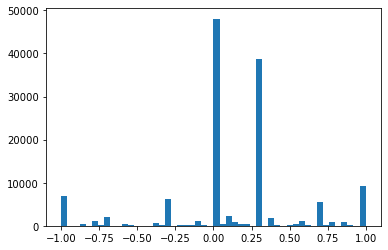

In [12]:
import matplotlib.pyplot as plt

plt.hist(df['polarized_score'], bins=50)
plt.show()

## Prepare to construct named entity dictionary

In [ ]:
# make a named entity list
KEYWORDS = ['corn','oats','wheat','soybean','rice','grains']

ents = df['ents'].to_list()
ents = [item for item in ents if item]
ents = list(set([str(item) for sublist in ents for item in sublist]))+KEYWORDS
len(ents)

## Calculate using co-occurence matrix and PMI

In [16]:
# cutoff for neg/neu/pos classification: -0.25/0.25

def classify_sentiment(x):
    if x <= -0.25:
        return -1
    elif x >= 0.25:
        return 1
    else:
        return 0


df['sentiment'] = df['polarized_score'].apply(classify_sentiment)
df.head()

,headline,query,date,hashtag,source,hashtags,VADER_compound,HIV4_score,LM_score,TextBlob_polarity,TextBlob_subjectivity,headline_tk,ents,total_score,HIV4_LM_agreement,overall_polarity,polarized_score,sentiment
27,"Wheat down 3%; soy, corn also sag on pre-holid...",corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,-0.155556,0.288889,wheat soy corn also sag slide,(),-0.300000,-1,-1,-0.300000,-1
28,Wheat pauses after three-week high in pre-holi...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,0.160000,0.540000,wheat paus high lull,(),-0.300000,-1,1,0.300000,1
29,"Wheat gains for 4th session, at near 3-week to...",corn,2020-11-25 00:00:00,None,news,NaN,0.1027,-0.999999,-0.999999,0.300000,0.450000,wheat gain session near top crop worri,"((week),)",-0.999999,1,1,-0.999999,-1
30,Wheat hits near three-week high on USDA's crop...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,1.000000,-0.999999,0.130000,0.470000,wheat hit near high usda crop qualiti downgrad,(),-0.399999,-1,1,0.399999,1
31,Wheat climbs to 2-week top on U.S. ratings; co...,corn,2020-11-24 00:00:00,None,news,NaN,-0.1027,0.000000,0.000000,0.500000,0.500000,wheat climb top rate corn drift lower,"((us),)",0.000000,1,1,0.000000,0


In [17]:
from collections import Counter

stop_words = set(stopwords.words('english'))

def convert_corpus_to_lexicon(df, sl):
    corpus = [w.split(' ') for w in df[df['sentiment']==sl]['headline_tk'].to_list()]
    corpus = [item for sublist in corpus for item in sublist] # flatten
    
    corpus_threshold = sum([v for v in dict(Counter(corpus)).values()]) * 0.00005
    lexicon = [k for k,v in dict(Counter(corpus)).items() if v>=corpus_threshold]
    lexicon = [word for word in lexicon if word not in ents]
    
    # remove stopwords from lexicon and corpus
    lexicon = [word for word in lexicon if word not in stop_words]
    corpus = [word for word in corpus if word not in stop_words]
    return lexicon, corpus

sentiment_levels = [-1, 0, 1]

lexicons = {}
corpuses = {}
for sl in sentiment_levels:
    lexicons[sl], corpuses[sl] = convert_corpus_to_lexicon(df, sl=sl)

# eg.
print(lexicons[-1][:10])
print(corpuses[-1][:10])

['soy', 'also', 'slide', 'gain', 'session', 'near', 'top', 'crop', 'worri', 'new']
['wheat', 'soy', 'corn', 'also', 'sag', 'slide', 'wheat', 'gain', 'session', 'near']


In [28]:
from tqdm import tqdm

total_lexicons = [corpuses[sl] for sl in sentiment_levels]
total_lexicons = [item for sublist in total_lexicons for item in sublist if item != ''] # flattten
lexicon_set = list(set(total_lexicons))
print(len(lexicon_set))

# Pointwise mutual information (PMI) calculation
"""
PMI(w,c) = log( p(w,c) / p(w) / p(c) )
representing the confidence of sentiment of word
then overall score for w is PMI(w,1) - PMI(w,-1)
"""
# calculate p(c)
p_c = {}
for sl in tqdm(sentiment_levels):
    p_c[sl] = len(corpuses[sl])/len(total_lexicons)

# calculate p(w)
lexicon_counter = Counter(total_lexicons)
p_w = {}
for lex in tqdm(lexicon_set):
    p_w[lex] = lexicon_counter[lex]/len(total_lexicons)

# calculate p(w,c)
p_wc = {}
pmi = {}

counter_courpuses = {}

for sl in tqdm(sentiment_levels):
    counter_courpuses[sl] = Counter(corpuses[sl])

for lex in tqdm(lexicon_set):
    for sl in sentiment_levels:
        p_wc[(lex, sl)] = counter_courpuses[sl][lex] / len(total_lexicons)
        pmi[(lex, sl)] = np.log(p_wc[(lex, sl)]/p_c[sl]/p_w[lex]) if p_wc[(lex, sl)] != 0 else 0      

lexicon_set[:10]

100%|██████████| 3/3 [00:00<00:00, 31.51it/s]

57494
hello1
hello2



 68%|██████▊   | 38976/57494 [00:00<00:00, 173577.79it/s]

hello3


100%|██████████| 57494/57494 [00:00<00:00, 203202.67it/s]


['shockwav',
 'maltster',
 'dietitiansdomedia',
 'myciti',
 'martinlutherk',
 'wheaten',
 'tabooleh',
 'dewa',
 'lrimal',
 'grainswholelettucecarrotlunchfriday']

## Generate lexicon scores

In [29]:
lexicon_scores = {}
for lex in lexicon_set:
    lexicon_scores[lex] = pmi[(lex, 1)] - pmi[(lex, -1)]

pmi_max = max(list(lexicon_scores.values()))
pmi_min = min(list(lexicon_scores.values()))

# normalize
# lexicon_scores = {k:(v-pmi_min)/(pmi_max-pmi_min)*2-1 for k,v in lexicon_scores.items()}

# filter out named entities
lexicon_scores = {k:v for k, v in lexicon_scores.items() if k not in ents}

print(len(lexicon_scores))
# print([(k,v) for k, v in lexicon_scores.items() if v >= 0.5])

53712


## Plot histogram of final word-level scores

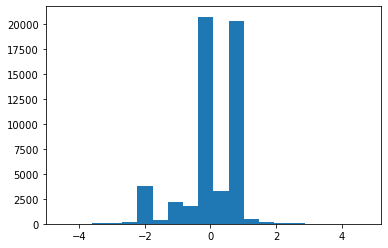

In [30]:
import matplotlib.pyplot as plt

plt.hist(list(lexicon_scores.values()), bins=20)
plt.show()

## Adjusted sentiment score for each news headlines

- Now we have `lexicon_scores` which contains a score for selected lexicons.
- We try to fit the scores back to the headlines

In [31]:
def generate_lexicon_score(h):
    score = 0
    for word in h.split(' '):
        if word in lexicon_scores.keys():
            score += lexicon_scores[word]
    return score

df['lexicon_score'] = df['headline_tk'].apply(generate_lexicon_score)

df.head(20)

,headline,query,date,hashtag,source,hashtags,VADER_compound,HIV4_score,LM_score,TextBlob_polarity,TextBlob_subjectivity,headline_tk,ents,total_score,HIV4_LM_agreement,overall_polarity,polarized_score,sentiment,lexicon_score
27,"Wheat down 3%; soy, corn also sag on pre-holid...",corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,-0.155556,0.288889,wheat soy corn also sag slide,(),-0.300000,-1,-1,-0.300000,-1,-0.850660
28,Wheat pauses after three-week high in pre-holi...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,-0.999999,0.000000,0.160000,0.540000,wheat paus high lull,(),-0.300000,-1,1,0.300000,1,-1.081770
29,"Wheat gains for 4th session, at near 3-week to...",corn,2020-11-25 00:00:00,None,news,NaN,0.1027,-0.999999,-0.999999,0.300000,0.450000,wheat gain session near top crop worri,"((week),)",-0.999999,1,1,-0.999999,-1,-2.895041
30,Wheat hits near three-week high on USDA's crop...,corn,2020-11-25 00:00:00,None,news,NaN,0.0000,1.000000,-0.999999,0.130000,0.470000,wheat hit near high usda crop qualiti downgrad,(),-0.399999,-1,1,0.399999,1,0.139748
31,Wheat climbs to 2-week top on U.S. ratings; co...,corn,2020-11-24 00:00:00,None,news,NaN,-0.1027,0.000000,0.000000,0.500000,0.500000,wheat climb top rate corn drift lower,"((us),)",0.000000,1,1,0.000000,0,-1.803978
32,U.S. farmers plant more winter wheat as grain ...,corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.999999,0.000000,0.500000,0.500000,farmer plant winter wheat grain price ralli,"((us), (winter))",0.300000,-1,1,0.300000,1,-0.410731
33,"Soybeans and corn slip from highs, wheat follows",corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.000000,0.000000,0.000000,0.000000,soybean corn slip high wheat follow,(),0.000000,1,1,0.000000,0,-0.963771
34,New Biofuel-Trading Venue Sees Untapped Demand...,corn,2020-11-24 00:00:00,None,news,NaN,-0.1280,0.999999,0.000000,-0.031818,0.377273,new venu see untap demand green reviv,(),0.300000,-1,-1,-0.300000,-1,-2.134792
35,Wheat extends gains as adverse weather forecas...,corn,2020-11-24 00:00:00,None,news,NaN,-0.2960,-1.000000,-1.000000,0.000000,0.000000,wheat extend gain advers weather forecast thre...,(),-1.000000,1,1,-1.000000,-1,-8.930526
36,Soybeans fall for first time in eight sessions,corn,2020-11-24 00:00:00,None,news,NaN,0.0000,0.000000,0.000000,0.250000,0.333333,soybean fall first time eight session,"((first), (eight))",0.000000,1,1,0.000000,0,-0.616759


In [32]:
df = df.sort_values('lexicon_score',ascending=False)
df[['headline','lexicon_score']].iloc[999:1010]

,headline,lexicon_score
100545,dr alex mereacre on the panel at the india te...,15.604827
118005,"every ingredient ✨vegetable, fruit, spice, gra...",15.600375
51132,why must you add fiber in your diet? fiber has...,15.598216
102591,easy ways to increase your fibre intake is to ...,15.595971
105365,jalapeño poppers and cbs! who was lucky enoug...,15.595615
102757,shoutout to those late christmas days with fam...,15.594781
123196,radar nuitun front froid a traversé le nordoue...,15.591324
79880,herbal concepts is filled with herbs amp; grai...,15.586256
131037,‼️buy natural spices online at best price gre...,15.584267
113718,tradesparent with cargill at the global grain ...,15.582235


# Ouput the lexicon database and dataframe

In [33]:
import json

with open('./lexicon_scores.json', 'w+') as f:
    json.dump(lexicon_scores,f)

df.to_csv('./dataframe.csv', index=False)

In [49]:
ents

['uschina trade news',
 'the dog days of summer',
 'kim',
 'grainssoybeans ease ahead',
 'world vegoil',
 'geopolitical skirmishes trigger ag',
 'arc plc',
 'this week january',
 'autumn',
 'bunge',
 'kevin mcnew',
 'bitcoin',
 'qa bryan',
 'argentine agroexport industry workers',
 'yesterday',
 'adjust n',
 'al kluis longterm',
 'brazilian',
 'four',
 'nopa december',
 'grainscorn gains lingers',
 'bioag alliance advances',
 'kemx global',
 'lagarde imf',
 'hour',
 'ragesray grabanski',
 'northwest il',
 'soil food web analysis',
 'syrian',
 'asia ricevirus',
 'alltech',
 'us farm landscapes',
 'naftas',
 'nigerian',
 'oregon',
 'cme group buys kcbt',
 'west african',
 'toban dyck',
 'refine higholeic soybean',
 'sichuan province',
 'wyoming',
 'grains shrug',
 'homebuilt variablerate',
 'carolinas',
 'asia ricevietman',
 'dazn sports streaming service',
 'bearish combo greets',
 'dallas',
 'refilecanadian',
 'pepsico',
 'primer nitrogen',
 'mexican',
 'russias rdif italys barilla',
 